In [1]:
# check here: https://pytorch.org/vision/stable/models.html

In [ ]:
# TODO: I am not conviced that I am extracting the image tiles in the correct way.

In [2]:
from torchvision.models import resnet50, ResNet50_Weights
import torch
import os
import re
import scanpy as sc
import cv2
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import umap

/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/philipp/miniconda3/envs/torch_env2/lib/python3.9/site-

In [3]:
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
#model = torch.nn.Sequential(*(list(model.children())[:-1]))
model.fc = torch.nn.Identity()  # remove last layer

In [4]:
current_folder = globals()['_dh'][0]
visium_dir = current_folder / ".." / ".." / "data" / "uscsc_dump"
spot_images = current_folder / ".." / ".." / "data" / "spot_images"

In [14]:
samples = [f for f in os.listdir(visium_dir) if f.startswith("visium")]
{i: smp for i, smp in enumerate(samples)}

{0: 'visium_MS197D.h5ad',
 1: 'visium_MS94.h5ad',
 2: 'visium_MS497I.h5ad',
 3: 'visium_CO85.h5ad',
 4: 'visium_MS377I.h5ad',
 5: 'visium_MS466.h5ad',
 6: 'visium_MS377T.h5ad',
 7: 'visium_CO74.h5ad',
 8: 'visium_MS411.h5ad',
 9: 'visium_MS229.h5ad',
 10: 'visium_MS197U.h5ad',
 11: 'visium_CO40.h5ad',
 12: 'visium_CO96.h5ad',
 13: 'visium_MS371.h5ad',
 14: 'visium_MS549H.h5ad',
 15: 'visium_MS549T.h5ad',
 16: 'visium_MS497T.h5ad'}

In [6]:
smp = samples[3]
print(smp)
base_name = re.sub(r"\.h5ad$", "", smp)
base_name = re.sub(r"^visium_", "", base_name)
vis_adata = sc.read_h5ad(visium_dir / smp)
vis_adata.var_names_make_unique()
print("Number of spots:", vis_adata.shape[0])

visium_CO85.h5ad
Number of spots: 3294


In [7]:
# TODO: I am not sure whether I am reading in the images in the correct way
# See here: https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html
transform = ResNet50_Weights.IMAGENET1K_V2.transforms()
features = np.zeros((len(vis_adata), 2048))
#for i, img_name in enumerate(imgs):
for i, barcode in enumerate(vis_adata.obs_names):
    img_path = str(spot_images / base_name / (barcode + ".jpeg"))

    # see here: https://github.com/BiomedicalMachineLearning/stLearn/blob/09c8d7a79979268fe78273fcb25726c5e94c2c6c/stlearn/image_preprocessing/feature_extractor.py#L60
    # and here: https://github.com/BiomedicalMachineLearning/stLearn/blob/09c8d7a79979268fe78273fcb25726c5e94c2c6c/stlearn/image_preprocessing/model_zoo.py#LL54C12-L54C12
    # we need to make sure to use the same transforms as in the original training
    img = Image.open(img_path)
    img = transform(img)
    img = img.unsqueeze(0)
    features[i, :] = model.forward(img).detach().numpy()

In [8]:
# make pca of the features
pca_coords = PCA(n_components=50).fit_transform(features)

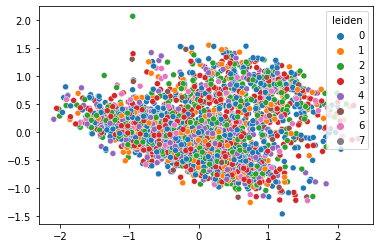

In [9]:
# plot the first two components, color by vis_adata.obs.leiden using seaborn
sns.scatterplot(x=pca_coords[:, 0], y=pca_coords[:, 1], hue=vis_adata.obs.leiden)
plt.show()

In [16]:
vis_adata.obs.columns

Index(['in_tissue', 'array_row', 'array_col', 'n_genes', 'Astros', 'Astros_c',
       'B-cells', 'Endothelia', 'Macrophages_f', 'Microglia', 'OPC', 'Oligos',
       'Oligos_d', 'Stroma', 'T-cells', 'sample_id', 'lesion_type', 'leiden',
       'Androgen', 'EGFR', 'Estrogen', 'Hypoxia', 'JAK-STAT', 'MAPK', 'NFkB',
       'PI3K', 'TGFb', 'TNFa', 'Trail', 'VEGF', 'WNT', 'p53'],
      dtype='object')

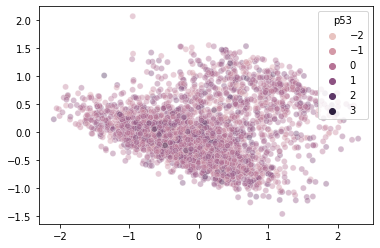

In [25]:
# make alpha = 0.2
sns.scatterplot(x=pca_coords[:, 0], y=pca_coords[:, 1], hue=vis_adata.obs.p53, alpha=0.4)
plt.show()

In [ ]:
# make umap of the features
umap_coords = umap.UMAP(n_components=2).fit_transform(features)

<Axes: >

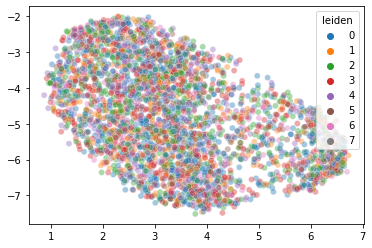

In [20]:
# plot umap coords, color by vis_adata.obs.leiden using seaborn
sns.scatterplot(x=umap_coords[:, 0], y=umap_coords[:, 1], hue=vis_adata.obs.leiden, alpha=0.4)

# Appendix

In [11]:
barcode = vis_adata.obs_names[0]
img_path = str(spot_images / base_name / (barcode + ".jpeg"))
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = Image.fromarray(img)
img = img.resize((224, 224))
img = np.array(img)
img = np.transpose(img, (2, 0, 1))
img = img / 255
img = torch.from_numpy(img).float()
img = img.unsqueeze(0)
img.shape

torch.Size([1, 3, 224, 224])

In [12]:
barcode = vis_adata.obs_names[0]
img_path = str(spot_images / base_name / (barcode + ".jpeg"))
img = Image.open(img_path)
img = np.asarray(img, dtype="int32")
img = img.astype(np.float32)
img = np.stack([img])

# The images are converted from RGB to BGR, then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.

img = np.transpose(img, (0, 3, 1, 2))
img = torch.from_numpy(img).float()
model.forward(img).detach().numpy()

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

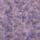

In [13]:
barcode = vis_adata.obs_names[10]
img_path = str(spot_images / base_name / (barcode + ".jpeg"))
img = Image.open(img_path)
img